### Prophet

In [439]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [440]:
pd.set_option("display.precision", 8)

In [441]:
indexes = pd.read_excel("/Users/khetag/Downloads/data_akbilgic.xlsx")

Начнем с того, что в таблице написаны не сами значения индексов, а их каждодневные относительные изменения, преобразуем значения в относительные относительно значения на момент 4 января 2009 года

In [442]:
columns = list(indexes.iloc[0])
columns[1] = 'ISE_turkish'

Кроме того давайте удалим первый столбец ISE(он изверяется в лирах, у нас уже есть столбец который измеряется в долларах, предсказать курс лиры не наша цель)

In [443]:
from datetime import datetime as dt
indexes.columns = columns
indexes.iloc[0] = ['2009-01-04 00:00:00', '100','100','100','100', '100','100','100','100','100']
indexes = indexes.drop(columns=["ISE_turkish"])
columns = indexes.columns
indexes.date = indexes.date.apply(lambda x: dt.fromisoformat(str(x)))
indexes

,date,ISE,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,2009-01-04,100,100,100,100,100,100,100,100
1,2009-01-05,0.03837619,-0.00467931,0.00219342,0.00389438,0,0.03119023,0.01269804,0.02852446
2,2009-01-06,0.03181274,0.00778674,0.00845534,0.01286561,0.00416245,0.01891958,0.01134065,0.00877264
3,2009-01-07,-0.02635297,-0.03046913,-0.01783306,-0.02873459,0.01729293,-0.03589858,-0.0170728,-0.02001541
4,2009-01-08,-0.0847159,0.00339136,-0.01172628,-0.000466,-0.04006131,0.02828315,-0.00556096,-0.01942378
...,...,...,...,...,...,...,...,...,...
532,2011-02-16,0.0133999,0.00623799,0.00192516,0.00795226,0.00571749,0.01837079,0.00697461,0.00303899
533,2011-02-17,0.0159772,0.00307089,-0.00118625,0.00034503,0.00261955,0.00168569,-0.00058051,0.00103859
534,2011-02-18,-0.0016526,0.00192291,0.00287211,-0.00072307,0.00056828,0.00562792,0.00057157,0.00693787
535,2011-02-21,-0.01370599,-0.02074215,-0.01423886,-0.0112749,0.00135758,-0.01194168,-0.01261533,-0.00095774


In [444]:
def to_float(x):
    try:
        x = float(x)
    except ValueError:
        x = 0
    except TypeError:
        x = 0
    return x
for column in columns[1:]:
    indexes[column] = indexes[column].apply(to_float)

def weekdays(some_date):
    if some_date.weekday() == 5 or some_date.weekday() == 6:
        return None
    return some_date

Будем хранить в таблице относительные значения индексов относительно первого дня(в процентах)

In [445]:
import warnings
warnings.filterwarnings('ignore')
for i in range(1, len(indexes)):
    for column in columns[1:]:
        indexes[column].iloc[i] = indexes[column].iloc[i - 1]*(indexes[column].iloc[i] + 1)
indexes

,date,ISE,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,2009-01-04,100.00000000,100.00000000,100.00000000,100.00000000,100.00000000,100.00000000,100.00000000,100.00000000
1,2009-01-05,103.83761870,99.53206850,100.21934190,100.38943760,100.00000000,103.11902290,101.26980390,102.85244620
2,2009-01-06,107.14097818,100.30709864,101.06673061,101.68100905,100.41624520,105.06999150,102.41826950,103.75473410
3,2009-01-07,104.31749562,97.25082821,99.26440134,98.75924664,102.15273650,101.29812843,100.66970338,101.67804035
4,2009-01-08,95.48014489,97.58064117,98.10039947,98.71322493,98.06036416,104.16315879,100.10988329,99.70306866
...,...,...,...,...,...,...,...,...,...
532,2011-02-16,207.78899145,136.00663356,140.86720108,127.79798191,112.69190465,157.12819213,125.26082321,161.51020736
533,2011-02-17,211.10887835,136.42429511,140.70009736,127.84207656,112.98710707,157.39306203,125.18810742,161.67794944
534,2011-02-18,210.75999940,136.68662620,141.10420324,127.74963830,113.05131538,158.27885838,125.25966169,162.79965052
535,2011-02-21,207.87132537,133.85145129,139.09504010,126.30927428,113.20479192,156.38874353,123.67946985,162.64373143


Часть EDA уже выполнил мой коллега. Давайте сразу посмотрим насколько точно библиотека prophet предскажет индексы в последние 120 дней, для обучения модели возьмем все дни кроме последних 120

Библиотека prophet от Meta(запрещенная в РФ организация)

In [446]:
import prophet
predictor = prophet.Prophet()

In [447]:
days = 120
predict_days = 181
predictor.fit(df = indexes[['date', 'ISE']][:-days].rename(columns ={'date':'ds','ISE':'y'}))

14:14:55 - cmdstanpy - INFO - Chain [1] start processing
14:14:55 - cmdstanpy - INFO - Chain [1] done processing


In [448]:
future = predictor.make_future_dataframe(periods=predict_days)
forecast = predictor.predict(future)

In [449]:
forecast = forecast.rename(columns = {'ds':'date'})

In [450]:
indexes.dtypes

date       datetime64[ns]
ISE               float64
SP                float64
DAX               float64
FTSE              float64
NIKKEI            float64
BOVESPA           float64
EU                float64
EM                float64
dtype: object

In [451]:
total = pd.merge(forecast, indexes, on = 'date', how = 'inner').dropna()
forecast = total[['date', 'yhat']]
forecast = forecast.rename(columns = {'date':'ds'})

Посчитаем относительную абсолютную ошибку

In [452]:
import numpy as np
# forecast[-days:]
100*np.mean(abs(indexes["ISE"][-days:] - forecast['yhat'][-days:])/indexes["ISE"][-days:])

10.058158987487342

Мы достаточно точно предсказали цену акции, но на самом это не говорит нам о многом, давайте посчитаем как часто мы угадываем вырастет акция в этот день или нет

In [453]:
predict_dynamic = (forecast[-days:].reset_index().yhat - forecast[-days - 1:].reset_index().yhat).drop(index = days)
dynamic = (indexes[-days:].reset_index()['ISE'] - indexes[-days - 1:].reset_index()['ISE']).drop(index = days)
100*np.mean((((dynamic > 0) & (predict_dynamic > 0)) | ((dynamic < 0) & (predict_dynamic < 0))).apply(lambda x: int(x)))

52.5

Не очень точное предсказание, давайте попробуем сгрупировать по неделям

In [454]:
predict_dynamic = (forecast[-days::5].reset_index().yhat - forecast[-days - 5::5].reset_index().yhat).drop(index=24)
dynamic = (indexes[-days::5].reset_index()['ISE'] - indexes[-days - 5::5].reset_index()['ISE']).drop(index=24)
100*np.mean((((dynamic > 0) & (predict_dynamic > 0)) | ((dynamic < 0) & (predict_dynamic < 0))).apply(lambda x: int(x)))

45.83333333333333

Давайте посчитаем и для других колонок

In [455]:
for column in indexes.columns[2:]:
    predictor = prophet.Prophet()
    days = 120
    predict_days = 181
    predictor.fit(df = indexes.reset_index()[['date', column]][:-days].rename(columns ={'date':'ds',column:'y'}))
    future = predictor.make_future_dataframe(periods=predict_days)
    forecast = predictor.predict(future)
    forecast = forecast.rename(columns = {'ds':'date'})
    total = pd.merge(forecast, indexes, on = 'date', how = 'inner').dropna()
    forecast = total[['date', 'yhat']]
    forecast = forecast.rename(columns = {'date':'ds'})
    indexes = indexes.reset_index().drop(columns=['index'])
    last_60_dynamic = (indexes[-days:].reset_index() - indexes[-days - 1:].reset_index()).drop(index = days)[column]
    last_60_dynamic_predict = (forecast.yhat[-days:].reset_index()-forecast.yhat[-days - 1:].reset_index()).drop(index = days)['yhat']
    print(column)
    print(100*np.mean((((last_60_dynamic_predict >= 0) & (last_60_dynamic >= 0)) | ((last_60_dynamic_predict <= 0) & (last_60_dynamic <= 0))).apply(lambda x: int(x))))

14:14:55 - cmdstanpy - INFO - Chain [1] start processing
14:14:56 - cmdstanpy - INFO - Chain [1] done processing
14:14:56 - cmdstanpy - INFO - Chain [1] start processing
14:14:56 - cmdstanpy - INFO - Chain [1] done processing
14:14:56 - cmdstanpy - INFO - Chain [1] start processing


SP
46.666666666666664
DAX
48.333333333333336


14:14:56 - cmdstanpy - INFO - Chain [1] done processing
14:14:56 - cmdstanpy - INFO - Chain [1] start processing
14:14:56 - cmdstanpy - INFO - Chain [1] done processing
14:14:56 - cmdstanpy - INFO - Chain [1] start processing


FTSE
55.00000000000001
NIKKEI
50.0


14:14:56 - cmdstanpy - INFO - Chain [1] done processing
14:14:56 - cmdstanpy - INFO - Chain [1] start processing
14:14:56 - cmdstanpy - INFO - Chain [1] done processing
14:14:56 - cmdstanpy - INFO - Chain [1] start processing


BOVESPA
57.49999999999999
EU
52.5


14:14:57 - cmdstanpy - INFO - Chain [1] done processing


EM
52.5


Безобразие...Давайте снова попробуем агрегировать по неделям

In [456]:
for column in indexes.columns[2:]:
    predictor = prophet.Prophet()
    days = 120
    predict_days = 181
    predictor.fit(df = indexes.reset_index()[['date', column]][:-days].rename(columns ={'date':'ds',column:'y'}))
    future = predictor.make_future_dataframe(periods=predict_days)
    forecast = predictor.predict(future)
    forecast = forecast.rename(columns = {'ds':'date'})
    total = pd.merge(forecast, indexes, on = 'date', how = 'inner').dropna()
    forecast = total[['date', 'yhat']]
    forecast = forecast.rename(columns = {'date':'ds'})
    indexes = indexes.reset_index().drop(columns=['index'])
    last_60_dynamic = (indexes[-days::5].reset_index() - indexes[-days - 5::5].reset_index())[column]
    last_60_dynamic_predict = (forecast.yhat[-days::5].reset_index()-forecast.yhat[-days - 5::5].reset_index())['yhat']
    print(column)
    print(100*np.mean((((last_60_dynamic_predict >= 0) & (last_60_dynamic >= 0)) | ((last_60_dynamic_predict <= 0) & (last_60_dynamic <= 0))).apply(lambda x: int(x))))

14:14:57 - cmdstanpy - INFO - Chain [1] start processing
14:14:57 - cmdstanpy - INFO - Chain [1] done processing


SP
20.0


14:14:57 - cmdstanpy - INFO - Chain [1] start processing
14:14:57 - cmdstanpy - INFO - Chain [1] done processing
14:14:57 - cmdstanpy - INFO - Chain [1] start processing


DAX
64.0


14:14:57 - cmdstanpy - INFO - Chain [1] done processing
14:14:57 - cmdstanpy - INFO - Chain [1] start processing


FTSE
24.0


14:14:57 - cmdstanpy - INFO - Chain [1] done processing
14:14:57 - cmdstanpy - INFO - Chain [1] start processing
14:14:57 - cmdstanpy - INFO - Chain [1] done processing
14:14:58 - cmdstanpy - INFO - Chain [1] start processing


NIKKEI
32.0
BOVESPA
44.0


14:14:58 - cmdstanpy - INFO - Chain [1] done processing
14:14:58 - cmdstanpy - INFO - Chain [1] start processing
14:14:58 - cmdstanpy - INFO - Chain [1] done processing


EU
32.0
EM
36.0


Тем не менее давайте посмотрим на конечное значение индексов

In [457]:
for column in indexes.columns[1:]:
    predictor = prophet.Prophet()
    days = 120
    predict_days = 181
    predictor.fit(df = indexes.reset_index()[['date', column]][:-days].rename(columns ={'date':'ds',column:'y'}))
    future = predictor.make_future_dataframe(periods=predict_days)
    forecast = predictor.predict(future)
    forecast = forecast.rename(columns = {'ds':'date'})
    total = pd.merge(forecast, indexes, on = 'date', how = 'inner').dropna()
    forecast = total[['date', 'yhat']]
    forecast = forecast.rename(columns = {'date':'ds'})
    print(column)
    print(f'мы предсказали {forecast.yhat.iloc[536]} на самом деле: {indexes[column].iloc[536]}')

14:14:58 - cmdstanpy - INFO - Chain [1] start processing
14:14:58 - cmdstanpy - INFO - Chain [1] done processing
14:14:58 - cmdstanpy - INFO - Chain [1] start processing
14:14:58 - cmdstanpy - INFO - Chain [1] done processing
14:14:58 - cmdstanpy - INFO - Chain [1] start processing


ISE
мы предсказали 204.68882859713597 на самом деле: 203.8299222461267
SP
мы предсказали 93.5587813034208 на самом деле: 133.85145128890417


14:14:58 - cmdstanpy - INFO - Chain [1] done processing
14:14:58 - cmdstanpy - INFO - Chain [1] start processing
14:14:58 - cmdstanpy - INFO - Chain [1] done processing


DAX
мы предсказали 119.30064806852987 на самом деле: 139.02929377224285
FTSE
мы предсказали 93.85189515060304 на самом деле: 125.93071212556148


14:14:59 - cmdstanpy - INFO - Chain [1] start processing
14:14:59 - cmdstanpy - INFO - Chain [1] done processing
14:14:59 - cmdstanpy - INFO - Chain [1] start processing
14:14:59 - cmdstanpy - INFO - Chain [1] done processing
14:14:59 - cmdstanpy - INFO - Chain [1] start processing


NIKKEI
мы предсказали 68.00965393246082 на самом деле: 111.17620439044165
BOVESPA
мы предсказали 138.28347110622477 на самом деле: 154.47273839507542


14:14:59 - cmdstanpy - INFO - Chain [1] done processing
14:14:59 - cmdstanpy - INFO - Chain [1] start processing
14:14:59 - cmdstanpy - INFO - Chain [1] done processing


EU
мы предсказали 96.39335556739866 на самом деле: 123.00357465499603
EM
мы предсказали 144.8584420892325 на самом деле: 160.31842522457436


Наиболее удачно получилось построить 'ISE', давайте построим для него график

In [458]:
def weekdays(some_date):
    if some_date.weekday() == 5 or some_date.weekday() == 6:
        return None
    return some_date
import plotly.graph_objects as go
predictor = prophet.Prophet()
days = 120
predict_days = 181
indexes[['date', "ISE"]][:-days].rename(columns ={'date':'ds','ISE':'y'})
predictor.fit(df = indexes.reset_index()[['date', 'ISE']][:-days].rename(columns ={'date':'ds','ISE':'y'}))
future = predictor.make_future_dataframe(periods=predict_days)
forecast = predictor.predict(future)
forecast = forecast.rename(columns = {'ds':'date'})
total = pd.merge(forecast, indexes, on = 'date', how = 'inner').dropna()
forecast = total[['date', 'yhat']]
forecast = forecast.rename(columns = {'date':'ds'})
fig = go.Figure()
fig.add_trace(go.Scatter(x = indexes['date'][-days:], y = indexes['ISE'][-days:]))
fig.add_trace(go.Scatter(x = forecast['ds'][-days:], y = forecast['yhat'][-days:]))
fig.show()
print(forecast.iloc[-1])
print(indexes.iloc[-1])

14:14:59 - cmdstanpy - INFO - Chain [1] start processing
14:14:59 - cmdstanpy - INFO - Chain [1] done processing


ds      2011-02-22 00:00:00
yhat            204.6888286
Name: 536, dtype: object
date       2011-02-22 00:00:00
ISE               203.82992225
SP                133.85145129
DAX               139.02929377
FTSE              125.93071213
NIKKEI            111.17620439
BOVESPA            154.4727384
EU                123.00357465
EM                160.31842522
Name: 536, dtype: object


В целом можно сделать вывод, что prophet больше подходит для больших датасетов и больших горизонтов предсказания, поэтому и предсказание на этом датасете такое неточное

### Sktime

Сделаем еще одно предсказание с помощью модели ARIMA. Для этого будем использовать библиотеку sktime.

In [459]:
from sktime.forecasting.arima import AutoARIMA

In [460]:
forecaster = AutoARIMA()

Как и в случае с первой моделью, в качестве тренировочного датасета возьмем все дни, кроме последних 120.

In [461]:
forecaster.fit(indexes[['date', 'ISE']][:-days].rename(columns ={'date':'ds','ISE':'y'}))

AutoARIMA()

In [462]:
ise_prediction = forecaster.predict(list(range(1,182)))

Приведем ise_prediction в нормальный вид (там что-то страшное с датами случилось).

In [463]:
ise_prediction = ise_prediction.reset_index()

In [464]:
indexes = indexes.reset_index()

In [465]:
ise_prediction = pd.merge(ise_prediction, indexes[['index', 'date', 'ISE']], on = 'index')

In [466]:
ise_prediction = ise_prediction.drop(['ds', 'index'], axis = 1).rename(columns = {'y' : 'predicted_ISE'})

In [467]:
total = ise_prediction.copy()

In [468]:
total

,predicted_ISE,date,ISE
0,195.89812332,2010-08-26,198.65690397
1,196.12809484,2010-08-27,199.81965772
2,196.35806636,2010-08-31,201.18091376
3,196.58803788,2010-09-01,204.27424674
4,196.81800939,2010-09-02,206.24711761
...,...,...,...
115,222.34484798,2011-02-16,207.78899145
116,222.57481949,2011-02-17,211.10887835
117,222.80479101,2011-02-18,210.75999940
118,223.03476253,2011-02-21,207.87132537


Посчитаем MAPE для предсказанных значений ISE:

In [469]:
100 * np.mean(abs(ise_prediction.predicted_ISE - ise_prediction.ISE) / ise_prediction.ISE)

8.633653618212572

Как мы можем видеть, ошибка получилась немного меньше, чем в Prophet модели. Давайте сделаем предсказание оставшихся индексов.

In [470]:
for column in indexes.columns[3::]:
    forecaster = AutoARIMA()
    forecaster.fit(indexes[['date', column]][:-days].rename(columns ={'date':'ds',column:'y'}))
    prediction = forecaster.predict(list(range(1,182)))
    prediction = prediction.reset_index()
    prediction = pd.merge(prediction, indexes[['index', 'date', column]], on = 'index')
    prediction = prediction.drop(['ds', 'index'], axis = 1).rename(columns = {'y' : 'predicted_' + column})
    total = pd.merge(total, prediction[['predicted_' + column, 'date', column]], on = 'date')

Теперь посмотрим на MAPE для каждого индекса:

In [471]:
for column in indexes.columns[2::]:
    print(column, end='\n')
    print('MAPE: ', 100 * np.mean(abs(total['predicted_' + column] - total[column]) / total[column]), end='\n\n')

ISE
MAPE:  8.633653618212572

SP
MAPE:  12.838855616540428

DAX
MAPE:  12.201202282684486

FTSE
MAPE:  11.373706975185085

NIKKEI
MAPE:  10.610014007318936

BOVESPA
MAPE:  5.574717454290458

EU
MAPE:  9.866219471028886

EM
MAPE:  5.461101197922458



Наименьшая ошибка у ISE, BOVESPA и EM.

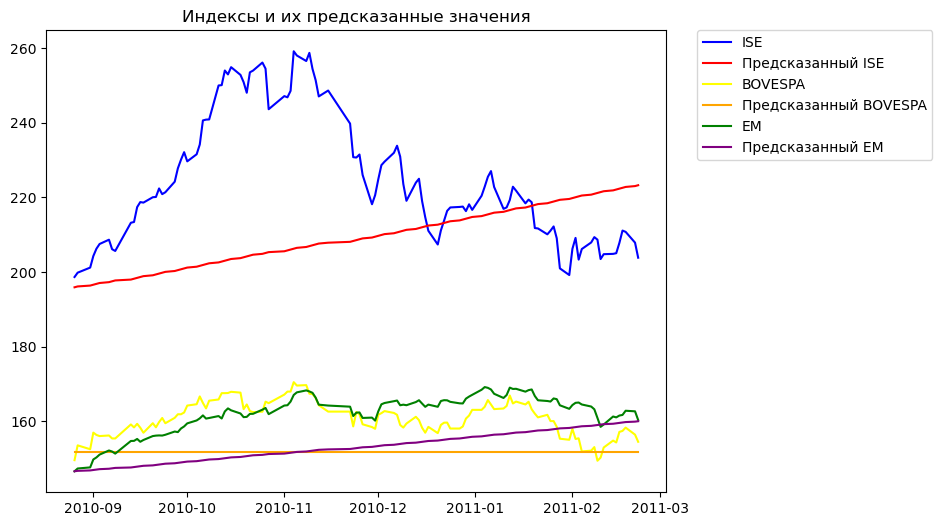

In [472]:
plt.figure(figsize=(8,6))

plt.plot(total.date, total.ISE, color = 'blue', label = 'ISE')
plt.plot(total.date, total.predicted_ISE, color = 'red', label = 'Предсказанный ISE')

plt.plot(total.date, total.BOVESPA, color = 'yellow', label = 'BOVESPA')
plt.plot(total.date, total.predicted_BOVESPA, color = 'orange', label = 'Предсказанный BOVESPA')

plt.plot(total.date, total.EM, color = 'green', label = 'EM')
plt.plot(total.date, total.predicted_EM, color = 'purple', label = 'Предсказанный EM')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Индексы и их предсказанные значения')
plt.show()